In [61]:
from time import time
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [62]:
df = pd.read_csv("../data/processed/stocks.csv")

In [63]:
df.head(10)

,date,close,volume,open,high,low,ticker,returns,rsi,kama,ema,tema,mfi,obv
0,2015-12-23,27.1525,130472560,26.8175,27.2125,26.8000,AAPL,-0.005340,41.899128,27.541394,27.504445,26.761478,18.818790,-5.739855e+08
1,2015-12-24,27.0075,54386720,27.2500,27.2500,26.9875,AAPL,-0.011201,40.616972,27.461440,27.414092,26.774391,15.911017,-6.283722e+08
2,2015-12-28,26.7050,106559720,26.8975,26.9225,26.5452,AAPL,0.017974,38.004155,27.368836,27.285166,26.664920,16.684601,-7.349319e+08
3,2015-12-29,27.1850,123649040,26.7400,27.3575,26.7150,AAPL,-0.013059,44.144184,27.360072,27.266954,26.825755,25.161975,-6.112829e+08
4,2015-12-30,26.8300,100736360,27.1450,27.1750,26.7950,AAPL,-0.019195,40.916589,27.338830,27.187508,26.786950,26.994879,-7.120192e+08
5,2015-12-31,26.3150,163541920,26.7525,26.7575,26.2050,AAPL,0.000855,36.721948,27.244140,27.028870,26.539136,28.212213,-8.755612e+08
6,2016-01-04,26.3375,270276360,25.6525,26.3420,25.5000,AAPL,-0.025059,37.025699,27.195120,26.903166,26.395319,26.852602,-6.052848e+08
7,2016-01-05,25.6775,222332560,26.4375,26.4625,25.6025,AAPL,-0.019570,32.150431,27.120373,26.680318,26.013921,29.931883,-8.276174e+08
8,2016-01-06,25.1750,273537080,25.1400,25.5925,24.9675,AAPL,-0.042205,29.017623,26.865129,26.406624,25.547331,28.607750,-1.101154e+09
9,2016-01-07,24.1125,322969840,24.6700,25.0325,24.1075,AAPL,0.005288,23.748276,26.346240,25.989510,24.775429,18.223352,-1.424124e+09


In [64]:
df.columns

Index(['date', 'close', 'volume', 'open', 'high', 'low', 'ticker', 'returns',
       'rsi', 'kama', 'ema', 'tema', 'mfi', 'obv'],
      dtype='object')

In [65]:
columns_to_drop = ['open', 'close', 'high', 'low', 'dollar_vol', 'dollar_vol_rank', 'volume'] 
print(f"Columns to drop: {columns_to_drop}")
print(f"Available columns: {list(df.columns)}")

# Only drop columns that actually exist
existing_lag_columns = [c for c in columns_to_drop if c in df.columns]
if existing_lag_columns:
    df = df.drop(existing_lag_columns, axis=1)
    print(f"Dropped {len(existing_lag_columns)} columns")
else:
    print("No lag columns found to drop")

Columns to drop: ['open', 'close', 'high', 'low', 'dollar_vol', 'dollar_vol_rank', 'volume']
Available columns: ['date', 'close', 'volume', 'open', 'high', 'low', 'ticker', 'returns', 'rsi', 'kama', 'ema', 'tema', 'mfi', 'obv']
Dropped 5 columns


In [66]:
df.set_index(['ticker', 'date'], inplace=True)

#### Split

In [67]:
dates_available = df.index.get_level_values('date').unique()
dates_available

Index(['2015-12-23', '2015-12-24', '2015-12-28', '2015-12-29', '2015-12-30',
       '2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
       ...
       '2025-10-29', '2025-10-30', '2025-10-31', '2025-11-03', '2025-11-04',
       '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-10', '2025-11-11'],
      dtype='object', name='date', length=2486)

In [68]:
split_index_id = int(np.floor(len(dates_available) * 0.8))
split_index_id

1988

In [69]:
split_date = dates_available[split_index_id]
split_date

'2023-11-16'

In [70]:
train_df = df[df.index.get_level_values('date') < split_date]
test_df = df[df.index.get_level_values('date') >= split_date]

In [71]:
print(train_df.shape)
print(test_df.shape)

(79520, 7)
(19920, 7)


In [72]:
y_train = train_df.filter(like='returns')
y_test = test_df.filter(like='returns')
X_train = train_df.drop(y_train.columns, axis=1)
X_test = test_df.drop(y_test.columns, axis=1)

In [73]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79520, 6)
(19920, 6)
(79520, 1)
(19920, 1)


In [74]:
X_train.head()

rsi       kama        ema       tema        mfi  \
ticker date                                                                
AAPL   2015-12-23  41.899128  27.541394  27.504445  26.761478  18.818790   
       2015-12-24  40.616972  27.461440  27.414092  26.774391  15.911017   
       2015-12-28  38.004155  27.368836  27.285166  26.664920  16.684601   
       2015-12-29  44.144184  27.360072  27.266954  26.825755  25.161975   
       2015-12-30  40.916589  27.338830  27.187508  26.786950  26.994879   

                           obv  
ticker date                     
AAPL   2015-12-23 -573985480.0  
       2015-12-24 -628372200.0  
       2015-12-28 -734931920.0  
       2015-12-29 -611282880.0  
       2015-12-30 -712019240.0

In [75]:
dates_df = X_train.reset_index()[['date']]
dates_df

,date
0,2015-12-23
1,2015-12-24
2,2015-12-28
3,2015-12-29
4,2015-12-30
...,...
79515,2023-11-09
79516,2023-11-10
79517,2023-11-13
79518,2023-11-14


In [76]:
class CV:
    """Generate tuples of train-idx, test_idx pairs"""
    def __init__(self,
            n_splits=3,
            train_period_length=63,  
            test_period_length=10,   
            lookahead=None):
        self.n_splits = n_splits
        self.train_length = train_period_length  
        self.test_length = test_period_length    
        self.lookahead = lookahead
        
    def split(self, X, y=None):

        unique_dates = X.index.get_level_values('date').unique()
        dates_df = X.reset_index()[['date']]
        
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1  
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])
                             
        for train_start, train_end, test_start, test_end in split_idx:
            if train_start >= len(days) or test_end < 0:
                continue
                
            train_idx = dates_df[(dates_df.date > days[train_start])
                                & (dates_df.date <= days[train_end])].index
            test_idx = dates_df[(dates_df.date > days[test_start])
                               & (dates_df.date <= days[test_end])].index
            
            if len(train_idx) > 0 and len(test_idx) > 0:  
                yield train_idx, test_idx

In [77]:
train_period_length = 63
test_period_length = 10
n_splits = int(len(X_train.index.get_level_values('date').unique()) / test_period_length) 
lookahead = 1

cv = CV(n_splits=n_splits,
        train_period_length=train_period_length,  
        test_period_length=test_period_length,    
        lookahead=lookahead)

In [78]:
i = 0
for train_idx, test_idx in cv.split(X=X_train):
    train = X_train.iloc[train_idx]
    test = X_train.iloc[test_idx]
    
    # Get actual date values
    train_dates = train.reset_index()['date']
    test_dates = test.reset_index()['date']
    
    # Count stocks per period and show date ranges
    train_stock_count = len(train['ticker'].unique()) if 'ticker' in train.columns else len(train)
    test_stock_count = len(test['ticker'].unique()) if 'ticker' in test.columns else len(test)
    
    print(f"Split {i+1}: 63 {train_dates.min()} to {train_dates.max()}, "
          f"10 {test_dates.min()} to {test_dates.max()}")
    
    i += 1
    if i == 10:
        break

Split 1: 63 2023-08-04 to 2023-11-01, 10 2023-11-02 to 2023-11-15
Split 2: 63 2023-07-21 to 2023-10-18, 10 2023-10-19 to 2023-11-01
Split 3: 63 2023-07-07 to 2023-10-04, 10 2023-10-05 to 2023-10-18
Split 4: 63 2023-06-22 to 2023-09-20, 10 2023-09-21 to 2023-10-04
Split 5: 63 2023-06-07 to 2023-09-06, 10 2023-09-07 to 2023-09-20
Split 6: 63 2023-05-23 to 2023-08-22, 10 2023-08-23 to 2023-09-06
Split 7: 63 2023-05-09 to 2023-08-08, 10 2023-08-09 to 2023-08-22
Split 8: 63 2023-04-25 to 2023-07-25, 10 2023-07-26 to 2023-08-08
Split 9: 63 2023-04-11 to 2023-07-11, 10 2023-07-12 to 2023-07-25
Split 10: 63 2023-03-27 to 2023-06-26, 10 2023-06-27 to 2023-07-11


In [79]:
# Set portfolio parameters
N_LONG = 5
N_SHORT = 5

In [80]:
# OLS (Linear Regression) Model
ols_model = LinearRegression()

In [81]:
ols_model.fit(X_train, y_train['returns'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [82]:
y_test_pred_ols = ols_model.predict(X_test)

In [83]:
y_test_pred_ols.shape

(19920,)

In [84]:
# Prepare test predictions (OLS)
test_predictions_ols = y_test[['returns']].copy()
test_predictions_ols['predicted_ols'] = y_test_pred_ols
test_predictions_ols.columns = ['actuals_ols', 'predicted_ols']
test_predictions_ols

actuals_ols  predicted_ols
ticker date                                  
AAPL   2023-11-16    -0.000105       0.000478
       2023-11-17     0.009278       0.000517
       2023-11-20    -0.004231       0.000441
       2023-11-21     0.003514       0.000429
       2023-11-22    -0.007004       0.000395
...                        ...            ...
XOM    2025-11-05     0.007213       0.000551
       2025-11-06     0.023755       0.000436
       2025-11-07     0.008531       0.000258
       2025-11-10     0.013196       0.000267
       2025-11-11    -0.013859       0.000239

[19920 rows x 2 columns]

In [85]:
# Convert to unstacked format for easy ranking (OLS)
predictions_unstacked_ols = test_predictions_ols['predicted_ols'].unstack('ticker')
actuals_unstacked_ols = test_predictions_ols['actuals_ols'].unstack('ticker')

In [86]:
# Generate trading signals (OLS)
long_signals_ols = ((predictions_unstacked_ols
                .where(predictions_unstacked_ols > 0)
                .rank(axis=1, ascending=False) <= N_LONG)
                .astype(int))

short_signals_ols = ((predictions_unstacked_ols
                  .where(predictions_unstacked_ols < 0)
                  .rank(axis=1, ascending=True) <= N_SHORT)
                  .astype(int))

In [87]:
# Calculate strategy returns (OLS)
long_returns_ols = (long_signals_ols * actuals_unstacked_ols).sum(axis=1) / long_signals_ols.sum(axis=1)
short_returns_ols = (short_signals_ols * (-actuals_unstacked_ols)).sum(axis=1) / short_signals_ols.sum(axis=1)
strategy_returns_ols = long_returns_ols.fillna(0) + short_returns_ols.fillna(0)

In [88]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    """Calculate the annualized Sharpe Ratio of a return series."""
    excess_returns = returns - risk_free_rate 
    avg_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()
    sharpe_ratio = (avg_excess_return / std_excess_return) * np.sqrt(252)
    return sharpe_ratio

In [89]:
print(f"OLS Strategy Sharpe Ratio: {sharpe_ratio(strategy_returns_ols):.4f}")

OLS Strategy Sharpe Ratio: 1.5606


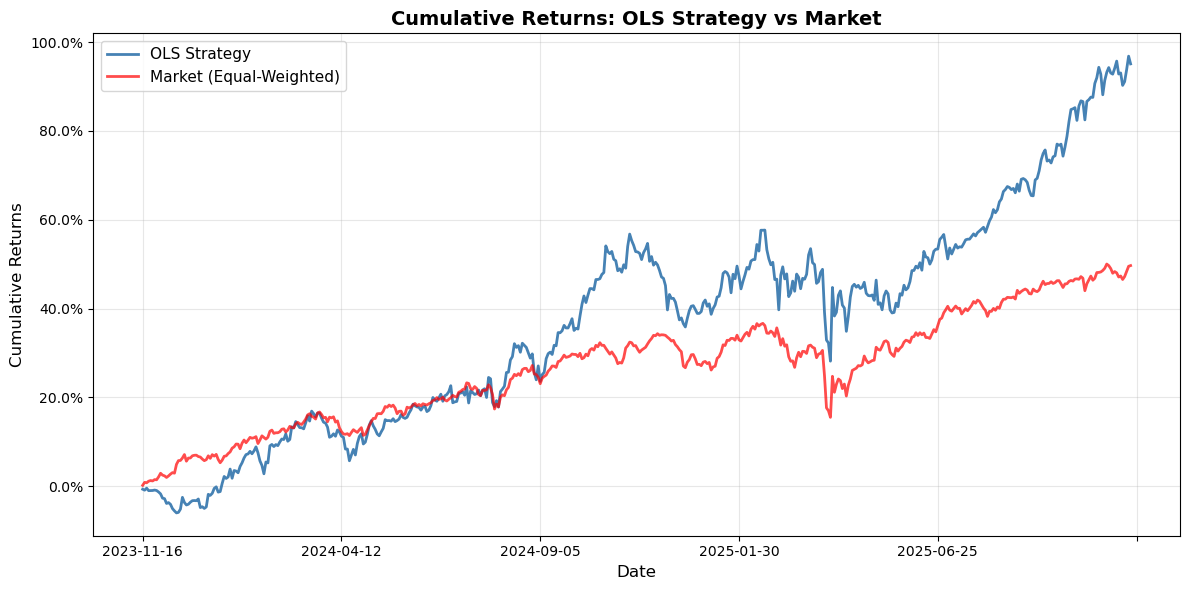

OLS Strategy Total Return: 95.11%
Market Total Return: 49.69%
OLS Strategy Sharpe Ratio: 1.56
Market Sharpe Ratio: 1.61


In [90]:
# Calculate cumulative returns for strategy (OLS)
cumulative_strategy_returns_ols = (1 + strategy_returns_ols).cumprod() - 1

# Calculate market benchmark (OLS)
market_returns_ols = actuals_unstacked_ols.mean(axis=1)
cumulative_market_returns_ols = (1 + market_returns_ols).cumprod() - 1

plt.figure(figsize=(12, 6))

cumulative_strategy_returns_ols.plot(label='OLS Strategy', color='steelblue', linewidth=2)
cumulative_market_returns_ols.plot(label='Market (Equal-Weighted)', color='red', alpha=0.7, linewidth=2)

plt.title('Cumulative Returns: OLS Strategy vs Market', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"OLS Strategy Total Return: {cumulative_strategy_returns_ols.iloc[-1]:.2%}")
print(f"Market Total Return: {cumulative_market_returns_ols.iloc[-1]:.2%}")
print(f"OLS Strategy Sharpe Ratio: {strategy_returns_ols.mean() / strategy_returns_ols.std() * np.sqrt(252):.2f}")
print(f"Market Sharpe Ratio: {market_returns_ols.mean() / market_returns_ols.std() * np.sqrt(252):.2f}")